In [ ]:
import pandas as pd
import torch
import re
import numpy as np
from transformers import EsmTokenizer, EsmModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch import nn
from torch.utils.data import DataLoader, Dataset
from Bio.PDB import PDBParser, PDBList, Select, DSSP
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.PDB.Polypeptide import PPBuilder, is_aa
import os
from sklearn.preprocessing import StandardScaler
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from Bio.SeqUtils import seq1

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [ ]:
df = pd.read_csv("skempi_v2.csv",sep=';')  # should have: sequence, position, wild, mutant, ddg

# Load the ESM model and tokenizer from HuggingFace
tokenizer = EsmTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
model = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D")
#tokenizer = EsmTokenizer.from_pretrained("facebook/esm1v_t33_650M_UR90S_1")
#model = EsmModel.from_pretrained("facebook/esm1v_t33_650M_UR90S_1")
#tokenizer = EsmTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")
#model = EsmModel.from_pretrained("facebook/esm2_t33_650M_UR50D")
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


In [ ]:
def get_chain_sequence(pdb_id, chain_id):
    pdb_id = pdb_id.lower()
    pdb_file = pdbl.retrieve_pdb_file(pdb_id, pdir=pdb_dir, file_format="pdb")
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure(pdb_id, pdb_file)
    
    for model in structure:
        for chain in model:
            if chain.id == chain_id:
                ppb = PPBuilder()
                sequence = ""
                for pp in ppb.build_peptides(chain):
                    sequence += str(pp.get_sequence())
                return sequence
    return None
def get_esm_embedding(sequence):
    inputs = tokenizer(sequence, return_tensors="pt", truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    token_embeddings = outputs.last_hidden_state.squeeze(0)
    mask = inputs["attention_mask"].squeeze(0).bool()
    avg_embedding = token_embeddings[mask].mean(dim=0).cpu().numpy()
    return avg_embedding

pdb_dir = "pdbs/"
os.makedirs(pdb_dir, exist_ok=True)
pdbl = PDBList()


In [ ]:
feat = []
labels = []

import re
for idx, row in df.iterrows():
    if ',' in row['Mutation(s)_cleaned']:
        continue
    pdb_id = row['#Pdb'][0:4]
    chain_id = row['Mutation(s)_cleaned'][1]
    sequence = get_chain_sequence(pdb_id, chain_id)   
    
    position = re.search(r'[A-Za-z](\d+)[A-Za-z]', row['Mutation(s)_cleaned']).group(1)
    pos = int(position) - 1
    pos = int(position)


    mutated_seq = sequence[:pos] + row['Mutation(s)_cleaned'][-1] + sequence[pos+1:]
    wt_embedding = get_esm_embedding(sequence)
    mt_embedding = get_esm_embedding(mutated_seq)
    feature_vector = mt_embedding - wt_embedding
    
    ddg = ((8.314/4184)*(273.15 + 25.0)* np.log(row['Affinity_mut_parsed'])) - ((8.314/4184)*(273.15 + 25.0)* np.log(row['Affinity_wt_parsed']))
    if pd.isna(ddg):
        ddg = 0
    
    

    feat.append(feature_vector)
    labels.append(ddg)


In [13]:
X = np.array(feat)
y = np.array(labels)
print(y.shape)
print(df.shape)

(5112,)
(7085, 29)


In [14]:
class DdGDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Deep learning model
class DdGPredictor(nn.Module):
    def __init__(self, input_dim):
        super(DdGPredictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),  # Add batch normalization
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),  # Add batch normalization
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),   # Add batch normalization
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        return self.model(x)
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, clip_value=1.0):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_state = None
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        for features, labels in train_loader:
            features = features.to(device)
            
            labels = labels.to(device)
            
            
            optimizer.zero_grad()
            outputs = model(features)
            
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            #print(f"running_loss: {running_loss}")
        
        train_loss = running_loss / len(train_loader)
        #print(f"Length train_loader: {len(train_loader)}")
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for features, labels in val_loader:
                
                features = features.to(device)
                labels = labels.to(device)
                #print(labels)
                outputs = model(features)
                loss = criterion(outputs.squeeze(), labels)
                val_loss += loss.item()
        
        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.8f}, Val Loss: {val_loss:.8f}')
    
    # Load best model
    model.load_state_dict(best_model_state)
    return model, train_losses, val_losses

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=12)
print(y_train.shape)

(3271,)


Training model...
Epoch 1/50, Train Loss: 3.65091258, Val Loss: 3.18934996
Epoch 2/50, Train Loss: 2.97447360, Val Loss: 2.76532476
Epoch 3/50, Train Loss: 2.56992956, Val Loss: 2.75821407
Epoch 4/50, Train Loss: 2.35262227, Val Loss: 2.59459385
Epoch 5/50, Train Loss: 2.03283708, Val Loss: 2.38778279
Epoch 6/50, Train Loss: 1.85019746, Val Loss: 2.26784017
Epoch 7/50, Train Loss: 1.65016291, Val Loss: 2.29164638
Epoch 8/50, Train Loss: 1.56777665, Val Loss: 2.15955660
Epoch 9/50, Train Loss: 1.37395538, Val Loss: 2.10934553
Epoch 10/50, Train Loss: 1.24872661, Val Loss: 2.09669879
Epoch 11/50, Train Loss: 1.13234446, Val Loss: 2.09333877
Epoch 12/50, Train Loss: 1.03593351, Val Loss: 2.01076122
Epoch 13/50, Train Loss: 1.00702063, Val Loss: 2.05223190
Epoch 14/50, Train Loss: 0.95760739, Val Loss: 1.97584309
Epoch 15/50, Train Loss: 0.88235252, Val Loss: 2.05449402
Epoch 16/50, Train Loss: 0.83363795, Val Loss: 2.01272194
Epoch 17/50, Train Loss: 0.81649570, Val Loss: 1.96349644
Epoch

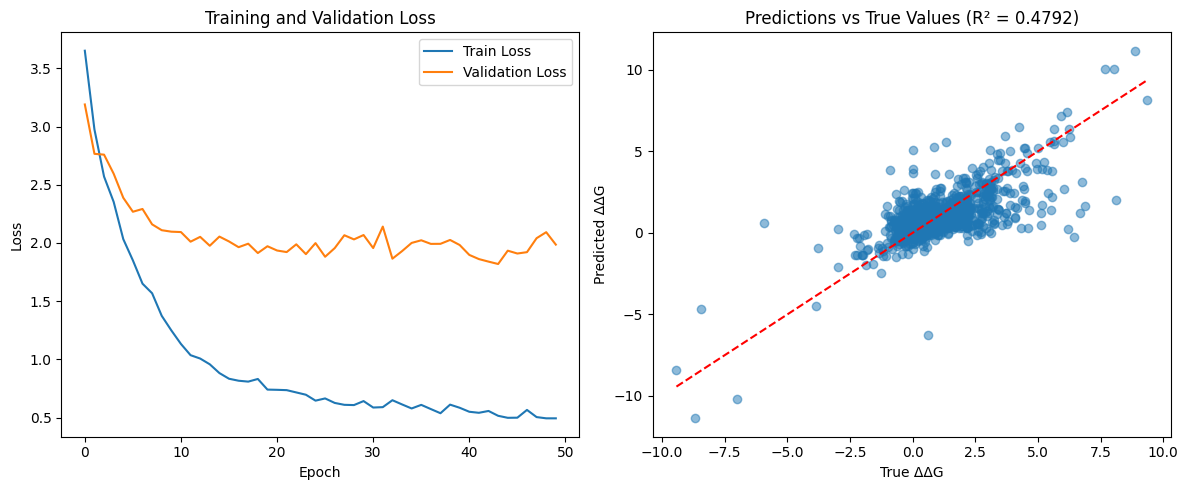

In [17]:

    
    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    # Create dataloaders
    train_dataset = DdGDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
    val_dataset = DdGDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val))
    test_dataset = DdGDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test))
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Initialize model
    input_dim = X_train.shape[1]  # ESM embedding dimension
    model = DdGPredictor(input_dim).to(device)
    
    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-6)
    
    # Train model
    print("Training model...")
    model, train_losses, val_losses = train_model(
        model, train_loader, val_loader, criterion, optimizer, num_epochs=50
    )
    
    # Evaluate model
    print("Evaluating model...")
    model.eval()
    y_pred = []
    y_true = []
    
    with torch.no_grad():
        for features, labels in test_loader:
            features = features.to(device)
            outputs = model(features)
            predictions = outputs.squeeze().cpu().numpy()
            y_pred.extend(predictions)
            y_true.extend(labels.numpy())
    
    # Calculate metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    print(f"Test Results:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R^2: {r2:.4f}")
    
    # Plot results
    plt.figure(figsize=(12, 5))
    
    # Plot loss curves
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    
    # Plot predictions vs true values
    plt.subplot(1, 2, 2)
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
    plt.xlabel('True ΔΔG')
    plt.ylabel('Predicted ΔΔG')
    plt.title(f'Predictions vs True Values (R² = {r2:.4f})')
    
    plt.tight_layout()
    plt.savefig('ddg_prediction_results.png')
    plt.show()